# SageMaker Processing for Video to Frame and Model Inference

Some business scenario need to processing videos by using manchine learning. They usually need extract frames from videos and then send them to models and get the result. This need you extract the frames and store in some place and then using batch transformer or online inference, which would involve a storage cost which is no longer need once infrenced. So customers are looking for a way to finish such job in a effective way, here we would introduce Amazon Sagemaker Processing.

Amazon SageMaker Processing, a new capability of Amazon SageMaker that lets customers easily run the
preprocessing, postprocessing and model evaluation workloads on fully managed infrastructure, was
announced during re:Invent 2019. 

In this sample, we would lauch a sagemaker processing job in a VPC, the input is videos in S3, and output is inference results (segmentation images) and will be stored in S3.

1. Launch an EC2 instance to play as API server which could be called by sagemaker processing job.
2. We use pretrained model to do semantic segmentation inference from GluonCV model zoo.
3. Enable Sagemaker Processing vpc mode so it could call API server.

Here is the high level architecture of this sample.

![High level architecture](https://sagemaker-us-west-2-169088282855.s3-us-west-2.amazonaws.com/video2frame/Picture1.png)

### GluonCV
[GluonCV](https://gluon-cv.mxnet.io/) provides implementations of state-of-the-art (SOTA) deep learning algorithms in computer vision. It aims to help engineers, researchers, and students quickly prototype products, validate new ideas and learn computer vision.

[GluonCV model zoo](https://gluon-cv.mxnet.io/model_zoo/index.html) contains six kinds of pretrained model: Classification, Object Detection, Segmentation, Pose Estimation, Action Recognition and Depth Prediction.

In this sample, we will use **deeplab_resnet101_citys** from Segmentation and was trained with **[cityscape dataset](https://www.cityscapes-dataset.com/)**, which focuses on semantic understanding of urban street scenes, so this model is suitable for car view images.

### Prerequisite

In order to download GPU supported pretrianed model, you need run this sample in **GPU based instance**, such as **ml.p2.xlarge or ml.p3.2xlarge**.

If you only launch none gpu instances in processing jobs, such as c5 type, you could run this demo in none gpu based instances. 

## Prepare pretrained model


In [ ]:
!pip install gluoncv==0.8

In [ ]:
import os

import boto3
import sagemaker
from sagemaker import get_execution_role

region = boto3.session.Session().region_name

role = get_execution_role()

Download pretrained model from GluonCV [model zoo](https://gluon-cv.mxnet.io/model_zoo/segmentation.html#cityscapes-dataset). We will use **deeplab_resnet101_citys** for demo.

In [2]:
import gluoncv
import mxnet as mx
from mxnet import image
from mxnet.gluon.data.vision import transforms


# if you would use GPU in later processing job(ml.p2, ml.p3 instances), here use mx.gpu(),otherwise here set mx.cpu()
#ctx = mx.cpu()
ctx = mx.gpu()

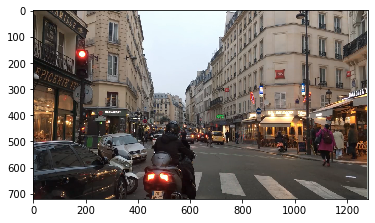

In [3]:
filename = 'paris.png'
#load the image
img = image.imread(filename)

from matplotlib import pyplot as plt
plt.imshow(img.asnumpy())
plt.show()

In [4]:
#normalize the image using dataset mean

from gluoncv.data.transforms.presets.segmentation import test_transform
img = test_transform(img, ctx)

In [5]:
#download pretrained model
model = gluoncv.model_zoo.get_model('deeplab_resnet101_citys', pretrained=True,ctx=ctx,root='./docker/mxnet/models')

100%|██████████| 239213/239213 [00:04<00:00, 56466.30KB/s]


In [6]:
#make prediction using single scale

output = model.predict(img)
predict = mx.nd.squeeze(mx.nd.argmax(output, 1)).asnumpy()

In [7]:
#Add color pallete for visualization
import matplotlib.image as mpimg
from gluoncv.utils.viz import get_color_pallete

mask = get_color_pallete(predict, 'citys')
mask.save('output.png')

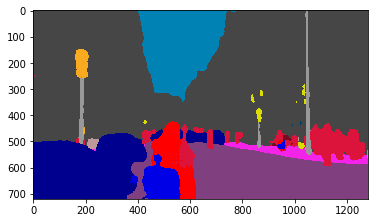

In [8]:
#show the predicted mask

mmask = mpimg.imread('output.png')
plt.imshow(mmask)
plt.show()

## Prepare docker image

We will using Sagemaker processing in BYOC mode, so first we need package our container.

We are using AWS Deep Learning Container as our base container, you can check the available list in https://aws.amazon.com/cn/releasenotes/available-deep-learning-containers-images/

Remember change the base container by the region you are using.

In [ ]:
%%writefile docker/Dockerfile
# https://aws.amazon.com/cn/releasenotes/available-deep-learning-containers-images/
FROM 763104351884.dkr.ecr.us-west-2.amazonaws.com/mxnet-training:1.6.0-gpu-py36-cu101-ubuntu16.04

RUN apt-get -y update && apt-get install -y --no-install-recommends \
         wget \
         libsm6 \
         libxrender1 \
         libglib2.0-dev \
         libxext6 \
    && rm -rf /var/lib/apt/lists/*

RUN pip3 install boto3 opencv-python requests gluoncv==0.8

# copy pretrained model to container
COPY mxnet /root/.mxnet/

ENV PYTHONUNBUFFERED=TRUE

ENTRYPOINT ["python3"]

In [ ]:
# Run this cell only onece to create the repository in ECR

account_id = boto3.client('sts').get_caller_identity().get('Account')
ecr_repository = 'video2frame-model-inference-sagemaker-processing-demo'
tag = ':latest'
uri_suffix = 'amazonaws.com'
if region in ['cn-north-1', 'cn-northwest-1']:
    uri_suffix = 'amazonaws.com.cn'
processing_repository_uri = '{}.dkr.ecr.{}.{}/{}'.format(account_id, region, uri_suffix, ecr_repository + tag)
print(processing_repository_uri)
ecr = '{}.dkr.ecr.{}.{}'.format(account_id, region, uri_suffix)

!aws ecr create-repository --repository-name $ecr_repository

In [ ]:
# if it said no basic auth for pull base image, use below cli (us-west-2)
!aws ecr get-login-password --region us-west-2 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-west-2.amazonaws.com

In [ ]:
!aws ecr get-login-password --region $region | docker login --username AWS --password-stdin $ecr

# Create ECR repository and push docker image
!docker build -t $ecr_repository docker

!docker tag {ecr_repository + tag} $processing_repository_uri
!docker push $processing_repository_uri

## Setup VPC Infrastructure

We will create below resources by cloudformation, make sure your notebook instance has been authorized to create below resources:

- VPC: AWS Virtual private cloud with CIDR block.
- Subnets: Two subnets with the CIDR blocks 192.168.0.0/24 and 192.168.1.0/24
- Security Group: Defining the open ingress and egress ports, such as TCP.
- VpcEndpoint: S3 Vpc endpoint allowing sagemaker's vpc cluster to dosenload data from S3.
- Route Table: Defining routes and is tied to subnets and VPC.
- EC2 instance to play as API Server


Complete cloud formation template for setting up the VPC stack can be seen here.

### Notice:
If you are using default role for sagemaker notebook instance, you need attach **AmazonEC2FullAccess** policy to your role NOW. 

In [ ]:
from time import sleep

import boto3
from botocore.exceptions import ClientError

def create_vpn_infra(stack_name):
    cfn = boto3.client("cloudformation")

    cfn_template = open("vpc_infra_cfn.json", "r").read()
    
    try:
        vpn_stack = cfn.create_stack(StackName=(stack_name),
                                     TemplateBody=cfn_template)
    except ClientError as e:
        if e.response['Error']['Code'] == 'AlreadyExistsException':
            print("Stack: {} already exists, so skipping stack creation.".format(stack_name))
        else:
            print("Unexpected error: %s" % e)
            raise e

    describe_stack = cfn.describe_stacks(StackName=stack_name)["Stacks"][0]

    while describe_stack["StackStatus"] == "CREATE_IN_PROGRESS":
        describe_stack = cfn.describe_stacks(StackName=stack_name)["Stacks"][0]
        sleep(0.5)

    if describe_stack["StackStatus"] != "CREATE_COMPLETE":
        raise ValueError("Stack creation failed in state: {}".format(describe_stack["StackStatus"]))

    print("Stack: {} created successfully with status: {}".format(stack_name, describe_stack["StackStatus"]))

    subnets = []
    security_groups = []

    for output_field in describe_stack["Outputs"]:

        if output_field["OutputKey"] == "SecurityGroupId":
            security_groups.append(output_field["OutputValue"])
        if output_field["OutputKey"] == "Subnet1Id" or output_field["OutputKey"] == "Subnet2Id":
            subnets.append(output_field["OutputValue"])
        if output_field["OutputKey"] == "APIServerAddr":
            api_server_addr = output_field["OutputValue"]

    return subnets, security_groups, api_server_addr

stack_name="processingvpcstack"

subnets, security_groups, api_server_addr = create_vpn_infra(stack_name="processingvpcstack")
print("Subnets: {}".format(subnets))
print("Security Groups: {}".format(security_groups))
print("API Server IP Address: {}".format(api_server_addr))

In [ ]:
vpc_security_group_ids = security_groups
vpc_subnets = subnets
vpc_api_server_address= api_server_addr

## Start processing job

In [ ]:
# change this to your data path in S3, for example s3://BUCKET/PATH/input/
# input_data = 'YOUR_INPUT_PATH_IN_S3'
# output_data = 'YOUR_OUTPUT_PATH_IN_S3'

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'video2frame'
input_data = 's3://{}/{}/input'.format(bucket, prefix)
output_data = 's3://{}/{}/output'.format(bucket, prefix)

#### Upload videos to S3 bucket

In [ ]:
# Upload video to S3, below is 2 sample videos of Paris and Beijing street scenes, you could use your own.
!wget https://sagemaker-us-west-2-169088282855.s3-us-west-2.amazonaws.com/video2frame/input/Paris.mp4
!wget https://sagemaker-us-west-2-169088282855.s3-us-west-2.amazonaws.com/video2frame/input/Beijing.mp4

sess.upload_data(path='Paris.mp4', bucket=bucket, key_prefix='{}/input'.format(prefix))
sess.upload_data(path='Beijing.mp4', bucket=bucket, key_prefix='{}/input'.format(prefix))

As we will lauch processing job in the vpc we created before, remember to set the VPC NetworkConfig.

In [ ]:
from sagemaker.network import NetworkConfig
from sagemaker.processing import (ProcessingInput, ProcessingOutput,
                                  ScriptProcessor)
"""
This network_config is for Enable VPC mode, which means the processing instance could access resources within vpc
change to your security_group_id and subnets_id
security_group_ids = ['YOUR_SECURITY_GROUP_ID']
subnets = ["YOUR_SUBNETS_ID1","YOUR_SUBNETS_ID2"]
"""
security_group_ids = vpc_security_group_ids
subnets = vpc_subnets

network_config = NetworkConfig(enable_network_isolation=False, 
                               security_group_ids=security_group_ids, 
                               subnets=subnets)

script_processor = ScriptProcessor(command=['python3'],
                image_uri=processing_repository_uri,
                role=role,
                instance_count=1,
                instance_type='ml.p3.2xlarge',
                network_config=network_config)

In [ ]:
# For arguments, you could pass parameters and as use them in your script by argparse

video_formats = [".mp4", ".avi"]
image_width = 1280
image_height = 720
frame_time_interval = 1000

script_processor.run(code='processing.py',
                      inputs=[ProcessingInput(
                        source=input_data,
                        destination='/opt/ml/processing/input_data',
                        s3_data_distribution_type='ShardedByS3Key')],
                      outputs=[ProcessingOutput(destination=output_data,
                                                source='/opt/ml/processing/output_data',
                                                s3_upload_mode = 'Continuous')],
                      arguments=['--api_server_address', vpc_api_server_address,
                                '--video_formats', "".join(video_formats),
                                '--image_width', str(image_width),
                                '--image_height', str(image_height),
                                '--frame_time_interval', str(frame_time_interval)]
                     )
script_processor_job_description = script_processor.jobs[-1].describe()
print(script_processor_job_description)

## Processing in parallel

If you have multi videos, you could set more than one instances, they would work in parallel, and get result faster.

In [ ]:
from sagemaker.network import NetworkConfig
from sagemaker.processing import (ProcessingInput, ProcessingOutput,
                                  ScriptProcessor)

instance_count = 2
"""
This network_config is for Enable VPC mode, which means the processing instance could access resources within vpc
change to your security_group_id and subnets_id
security_group_ids = ['YOUR_SECURITY_GROUP_ID']
subnets = ["YOUR_SUBNETS_ID1","YOUR_SUBNETS_ID2"]
"""
security_group_ids = vpc_security_group_ids
subnets = vpc_subnets

network_config = NetworkConfig(enable_network_isolation=False, 
                               security_group_ids=security_group_ids, 
                               subnets=subnets)

video_formats = [".mp4", ".avi"]
image_width = 1280
image_height = 720
frame_time_interval = 1000

script_processor = ScriptProcessor(command=['python3'],
                image_uri=processing_repository_uri,
                role=role,
                instance_count=instance_count,
                instance_type='ml.p3.2xlarge',
                network_config=network_config)

# with S3 shard key
script_processor.run(code='processing.py',
                      inputs=[ProcessingInput(
                        source=input_data,
                        destination='/opt/ml/processing/input_data',
                        s3_data_distribution_type='ShardedByS3Key')],
                      outputs=[ProcessingOutput(destination=output_data,
                                                source='/opt/ml/processing/output_data',
                                                s3_upload_mode = 'Continuous')],
                      arguments=['--api_server_address', vpc_api_server_address,
                                '--video_formats', "".join(video_formats),
                                '--image_width', str(image_width),
                                '--image_height', str(image_height),
                                '--frame_time_interval', str(frame_time_interval)]
                     )
script_processor_job_description = script_processor.jobs[-1].describe()
print(script_processor_job_description)

## Clear Resources

In [ ]:
# Delete vpc related resources

cfn = boto3.client("cloudformation")
response = cfn.delete_stack(StackName=stack_name)

## Reference

[GluonCV Model Zoo Segementation Cityscapes](https://gluon-cv.mxnet.io/model_zoo/segmentation.html#cityscapes-dataset)
[GluonCV model zoo api](https://gluon-cv.mxnet.io/api/model_zoo.html)

[SageMaker Processing Python SDK](https://sagemaker.readthedocs.io/en/stable/amazon_sagemaker_processing.html)

[Processor](https://sagemaker.readthedocs.io/en/stable/processing.html#sagemaker.processing.Processor)

[ScriptProcessor](https://sagemaker.readthedocs.io/en/stable/processing.html#sagemaker.processing.ScriptProcessor)

[ProcessingInput](https://sagemaker.readthedocs.io/en/stable/processing.html#sagemaker.processing.ProcessingInput)

[ProcessingOutput](https://sagemaker.readthedocs.io/en/stable/processing.html#sagemaker.processing.ProcessingOutput)

[ProcessingJob](https://sagemaker.readthedocs.io/en/stable/processing.html#sagemaker.processing.ProcessingJob)